In [1]:
from common_func import *
if type_of_script() == 'jupyter': from tqdm.notebook import tqdm
else: from tqdm import tqdm
    
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import colormaps
from matplotlib.colors import Normalize
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D, proj3d
#import cmasher as cmr

import numpy as np
import os, glob, atexit, signal, time, warnings, argparse, subprocess

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=1

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle

from importlib import reload
from copy import deepcopy
from multiprocessing import Pool, shared_memory, Value

# Analysis

In [2]:
mode1 = 'nh'
iout1 = 1026
repo, rurmode, dp = mode2repo(mode1)
nh1 = uri.RamsesSnapshot(repo, iout1, mode=rurmode)
nh1s = uri.TimeSeries(nh1)
nh1s.read_iout_avail()
nout1 = nh1s.iout_avail['iout']
gals1 = uhmi.HaloMaker.load(nh1, galaxy=True, double_precision=dp)
hals1 = uhmi.HaloMaker.load(nh1, galaxy=False, double_precision=dp)
database1 = f"/home/jeon/MissingSat/database"
LG1 = pklload(f"{database1}/LG")
keys1 = []
for key in LG1.keys():
    if(LG1[key]['isLG']): keys1.append(key)
keys1 = np.array(keys1)

mode2 = 'nh2'
iout2 = 797
repo, rurmode, dp = mode2repo(mode2)
nh2 = uri.RamsesSnapshot(repo, iout2, mode=rurmode)
nh2s = uri.TimeSeries(nh2)
nh2s.read_iout_avail()
nout2 = nh2s.iout_avail['iout']
gals2 = uhmi.HaloMaker.load(nh2, galaxy=True, double_precision=dp)
hals2 = uhmi.HaloMaker.load(nh2, galaxy=False, double_precision=dp)
database2 = f"/home/jeon/MissingSat/database/nh2"
LG2 = pklload(f"{database2}/LG")
keys2 = []
for key in LG2.keys():
    if(LG2[key]['isLG']): keys2.append(key)
keys2 = np.array(keys2)

[Output 01026] Age (Gyr) : 11.624 / 13.741, z = 0.17149 (a = 0.8536)
[Output 00797] Age (Gyr) : 11.623 / 13.741, z = 0.17158 (a = 0.8536)


## Cumulative Number

In [18]:
nMW = np.genfromtxt("NUMBER_MW.csv", comments='#', delimiter=',')
nMW[0]
nM31 = np.genfromtxt("NUMBER_M31.csv", comments='#', delimiter=',')
nM31[0]

array([6.77738036, 9.868339  ])

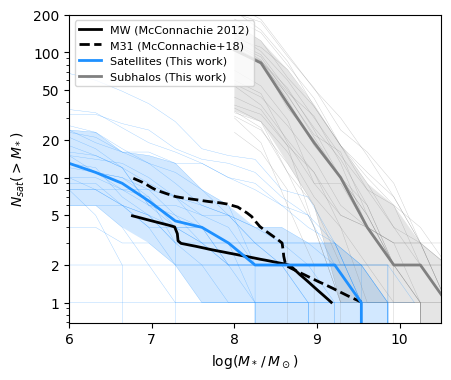

In [37]:
suffixs = ["all", "no_orp", "no_udg", "no_orp_udg"]
for ith in range(4):
    fig, ax = plt.subplots(figsize=(6*0.8,5*0.8))
    bins = np.logspace(6, 10.5, 15)
    hbins = np.logspace(8, 12.5, 15)

    chists1 = np.zeros((13, len(bins)-1))
    hhists1 = np.zeros((13, len(bins)-1))
    i=0
    for key in LG1.keys():
        if(not LG1[key]['isLG']): continue
        sats = LG1[key]['sats']
        subs = LG1[key]['subs']
        real = LG1[key]['real']
        if(ith%2==1): sats = sats[~isin(sats['id'], real['gid'][real['state'] == 'orphan'])]
        if(ith//2==1): sats = sats[~isin(sats['id'], real['gid'][real['state'] == 'upair'])]
        hist, he = np.histogram(subs['m'], bins = hbins)
        chist = np.cumsum(hist[::-1])[::-1]
        ax.plot(np.log10(he[:-1]), chist, color='grey', lw=0.25, alpha=0.5)
        hhists1[i] = chist
        hist, xe = np.histogram(sats['m'], bins = bins)
        chist = np.cumsum(hist[::-1])[::-1]
        ax.plot(np.log10(xe[:-1]), chist, color='dodgerblue', lw=0.25, alpha=0.5)
        chists1[i] = chist; i+=1

    chists2 = np.zeros((13, len(bins)-1))
    hhists2 = np.zeros((13, len(bins)-1))
    i=0
    for key in LG2.keys():
        if(not LG2[key]['isLG']): continue
        sats = LG2[key]['sats']
        subs = LG2[key]['subs']
        real = LG2[key]['real']
        if(ith%2==1): sats = sats[~isin(sats['id'], real['gid'][real['state'] == 'orphan'])]
        if(ith//2==1): sats = sats[~isin(sats['id'], real['gid'][real['state'] == 'upair'])]
        hist, he = np.histogram(subs['m'], bins = hbins)
        chist = np.cumsum(hist[::-1])[::-1]
        ax.plot(np.log10(he[:-1]), chist, color='grey', lw=0.25, alpha=0.5)
        hhists2[i] = chist
        hist, xe = np.histogram(sats['m'], bins = bins)
        chist = np.cumsum(hist[::-1])[::-1]
        ax.plot(np.log10(xe[:-1]), chist, color='dodgerblue', lw=0.25, alpha=0.5)
        chists2[i] = chist; i+=1

    ax.plot(nMW[:,0], nMW[:,1], color='k', lw=2, ls='-', label='MW (McConnachie 2012)')
    ax.plot(nM31[:,0], nM31[:,1], color='k', lw=2, ls='--', label='M31 (McConnachie+18)')

    chists = np.vstack((chists1, chists2))
    q16, q50, q84 = np.percentile(chists, [16,50,84], axis=0)
    ax.fill_between(np.log10(xe[:-1]), q16, q84, alpha=0.2, fc='dodgerblue', ec='none')
    ax.plot(np.log10(xe[:-1]), q50, color='dodgerblue', lw=2, ls='-', label='Satellites (This work)')
    
    hhists = np.vstack((hhists1, hhists2))
    q16, q50, q84 = np.percentile(hhists, [16,50,84], axis=0)
    ax.fill_between(np.log10(he[:-1]), q16, q84, alpha=0.2, fc='grey', ec='none')
    ax.plot(np.log10(he[:-1]), q50, color='grey', lw=2, ls='-', label='Subhalos (This work)')


    ax.set_xlim(6,10.5)
    ax.set_xlabel(r"log($M_*\,/\,M_\odot$)")
    ax.set_yscale('log')
    ax.set_ylim(0.69, 200)
    ax.set_yticks([1,2,5,10,20,50,100,200])
    ax.set_yticklabels([1,2,5,10,20,50,100,200])
    ax.set_ylabel(r"$N_{sat}(>M_*)$")
    ax.legend(loc='upper left', frameon=True, fontsize=8)
    plt.savefig(f"02_number_{suffixs[ith]}.png", dpi=400, transparent=False, bbox_inches='tight')
    plt.show(); plt.close()
    break

## Quenched Fraction

In [38]:
allsats1 = None
states1 = None
for key in LG1.keys():
    if(not LG1[key]['isLG']): continue
    sats = LG1[key]['sats']
    argsort = np.argsort(sats['id'])
    sats = sats[argsort]
    allsats1 = sats if(allsats1 is None) else np.hstack((allsats1, sats))
    real = LG1[key]['real']
    real = real[isin(real['gid'], sats['id'])]
    argsort = np.argsort(real['gid'])
    real = real[argsort]
    states1 = real['state'] if(states1 is None) else np.hstack((states1, real['state']))

allsats2 = None
states2 = None
for key in LG2.keys():
    if(not LG2[key]['isLG']): continue
    sats = LG2[key]['sats']
    argsort = np.argsort(sats['id'])
    sats = sats[argsort]
    allsats2 = sats if(allsats2 is None) else np.hstack((allsats2, sats))
    real = LG2[key]['real']
    real = real[isin(real['gid'], sats['id'])]
    argsort = np.argsort(real['gid'])
    real = real[argsort]
    states2 = real['state'] if(states2 is None) else np.hstack((states2, real['state']))

In [39]:
ssfrcut1 = 1 / (6*nh1.age*1e9); ssfrcut2 = 1 / (6*nh2.age*1e9)

### Choose Criterion

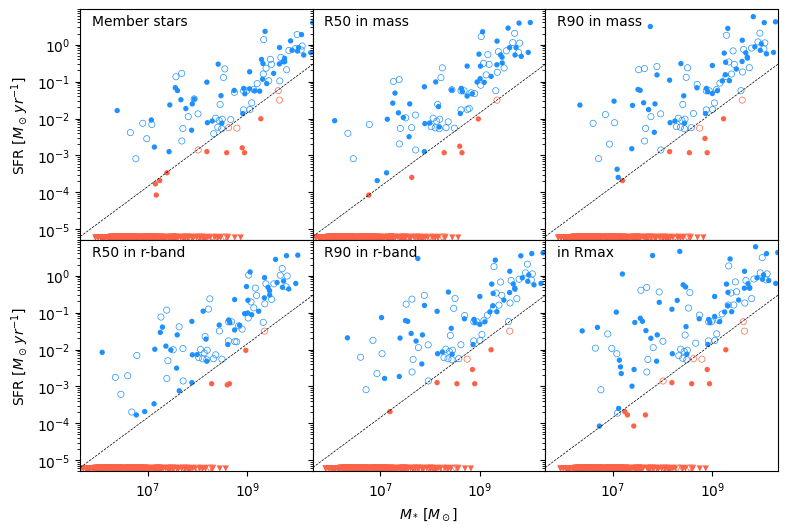

In [31]:
# fig, axes = plt.subplots(2,3, figsize=(9,6), sharex=True, sharey=True)
# plt.subplots_adjust(wspace=0, hspace=0)
# names = [i for i in allsats1.dtype.names if('SFR' in i)]
# titles = ["Member stars", "R50 in mass", "R90 in mass", "R50 in r-band", "R90 in r-band", "in Rmax"]
# factors = [1,0.5,0.9,0.5,0.9,1]
# x1 = np.min(allsats1['m']*0.5); x2 = np.max(allsats1['m'])
# for i in range(6):
#     ax = axes.flatten()[i]
#     factor = factors[i]

#     xs = allsats1['m']*factor
#     ys = allsats1[names[i]]*1.
#     mask1 = ys==0
#     ys[mask1] = 6e-6
#     mask2 = (ys/xs) < ssfrcut1

#     mask3 = allsats1['id']<0
#     ax.scatter(xs[~mask1 & mask2], ys[~mask1 & mask2], s=15, fc='tomato', ec='none', marker='o')
#     ax.scatter(xs[~mask1 & ~mask2], ys[~mask1 & ~mask2], s=15, fc='dodgerblue', ec='none', marker='o')
#     ax.scatter(xs[mask1], ys[mask1], s=20, fc='tomato', ec='none', marker='v')

# for i in range(6):
#     ax = axes.flatten()[i]
#     factor = factors[i]

#     xs = allsats2['m']*factor
#     ys = allsats2[names[i]]*1.
#     mask1 = ys==0
#     ys[mask1] = 6e-6
#     mask2 = (ys/xs) < ssfrcut1

#     mask3 = allsats2['id']<0
#     ax.scatter(xs[~mask1 & mask2], ys[~mask1 & mask2], s=20, ec='tomato', fc='none', marker='o', lw=0.5)
#     ax.scatter(xs[~mask1 & ~mask2], ys[~mask1 & ~mask2], s=20, ec='dodgerblue', fc='none', marker='o', lw=0.5)
#     ax.scatter(xs[mask1], ys[mask1], s=25, ec='tomato', fc='none', marker='v', lw=0.5)

#     ax.set_xscale('log')
#     ax.set_yscale('log')
#     ax.plot([x1,x2], [ssfrcut1*x1, ssfrcut1*x2], color='k', ls='--', lw=0.5)
#     ax.text(0.05,0.95, titles[i], ha='left', va='center', transform=ax.transAxes)
#     if(i==4): ax.set_xlabel(r"$M_*\,[M_\odot]$")
#     if(i%3==0): ax.set_ylabel(r"SFR $[M_\odot\,yr^{-1}]$")

# ax.set_ylim(5e-6, 9)
# ax.set_xlim(x1,x2)
# plt.savefig("02_SFMS_criteria.png", dpi=400, transparent=False, bbox_inches='tight')
# plt.show(); plt.close()

/tmp/ipykernel_32538/1845258920.py:56: RuntimeWarning: invalid value encountered in long_scalars
  QF[im] = np.sum(mask[binmask]) / np.sum(binmask)
/tmp/ipykernel_32538/1845258920.py:72: RuntimeWarning: invalid value encountered in long_scalars
  QF[im] = np.sum(mask[binmask]) / np.sum(binmask)


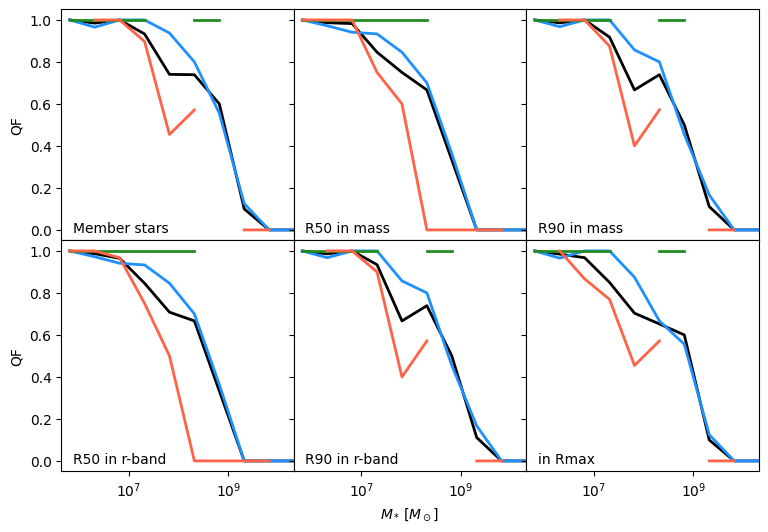

In [11]:
# fig, axes = plt.subplots(2,3, figsize=(9,6), sharex=True, sharey=True)
# plt.subplots_adjust(wspace=0, hspace=0)
# names = [i for i in allsats1.dtype.names if('SFR' in i)]
# titles = ["Member stars", "R50 in mass", "R90 in mass", "R50 in r-band", "R90 in r-band", "in Rmax"]
# factors = [1,0.5,0.9,0.5,0.9,1]
# x1 = np.min(allsats1['m']*0.5); x2 = np.max(allsats1['m'])
# mmin=5.5; mmax = 10.5; mdex = 0.5
# mbins = 10**np.arange(mmin, mmax+mdex, mdex); mleng = len(mbins)-1
# for i in range(6):
#     ax = axes.flatten()[i]
#     factor = factors[i]

#     xs = allsats1['m']*factor
#     ys = allsats1[names[i]]*1.
#     mask1 = ys==0; ys[mask1] = 6e-6
#     mask2 = (ys/xs) < ssfrcut1
#     mask = mask1 | mask2

#     QF = np.zeros(mleng)
#     MX = 0.5*(mbins[1:] + mbins[:-1])
#     for im in range(mleng):
#         binmask = (xs > mbins[im]) & (xs < mbins[im+1])
#         if(np.sum(binmask) == 0): QF[im] = np.nan
#         QF[im] = np.sum(mask[binmask]) / np.sum(binmask)
#     ax.plot(MX, QF, color='k', lw=2)
    
#     # Pair
#     pairs = allsats1[states1 == 'pair']
#     xs = pairs['m']*factor
#     ys = pairs[names[i]]*1.
#     mask1 = ys==0; ys[mask1] = 6e-6
#     mask2 = (ys/xs) < ssfrcut1
#     mask = mask1 | mask2

#     QF = np.zeros(mleng)
#     MX = 0.5*(mbins[1:] + mbins[:-1])
#     for im in range(mleng):
#         binmask = (xs > mbins[im]) & (xs < mbins[im+1])
#         if(np.sum(binmask) == 0): QF[im] = np.nan
#         QF[im] = np.sum(mask[binmask]) / np.sum(binmask)
#     ax.plot(MX, QF, color='dodgerblue', lw=2)
    
#     # only UDG
#     udgs = allsats1[states1=='upair']
#     xs = udgs['m']*factor
#     ys = udgs[names[i]]*1.
#     mask1 = ys==0; ys[mask1] = 6e-6
#     mask2 = (ys/xs) < ssfrcut1
#     mask = mask1 | mask2

#     QF = np.zeros(mleng)
#     MX = 0.5*(mbins[1:] + mbins[:-1])
#     for im in range(mleng):
#         binmask = (xs > mbins[im]) & (xs < mbins[im+1])
#         if(np.sum(binmask) == 0): QF[im] = np.nan
#         QF[im] = np.sum(mask[binmask]) / np.sum(binmask)
#     ax.plot(MX, QF, color='forestgreen', lw=2)

#     # Orphan
#     orphans = allsats1[states1=='orphan']
#     xs = orphans['m']*factor
#     ys = orphans[names[i]]*1.
#     mask1 = ys==0; ys[mask1] = 6e-6
#     mask2 = (ys/xs) < ssfrcut1
#     mask = mask1 | mask2

#     QF = np.zeros(mleng)
#     MX = 0.5*(mbins[1:] + mbins[:-1])
#     for im in range(mleng):
#         binmask = (xs > mbins[im]) & (xs < mbins[im+1])
#         if(np.sum(binmask) == 0): QF[im] = np.nan
#         QF[im] = np.sum(mask[binmask]) / np.sum(binmask)
#     ax.plot(MX, QF, color='tomato', lw=2)

#     ax.set_xscale('log')
#     ax.text(0.05,0.05, titles[i], ha='left', va='center', transform=ax.transAxes)
#     if(i==4): ax.set_xlabel(r"$M_*\,[M_\odot]$")
#     if(i%3==0): ax.set_ylabel(r"QF")
# ax.set_xlim(x1,x2)
# plt.savefig("02_QF_criteria.png", dpi=400, transparent=False, bbox_inches='tight')
# plt.show(); plt.close()

### Use membership

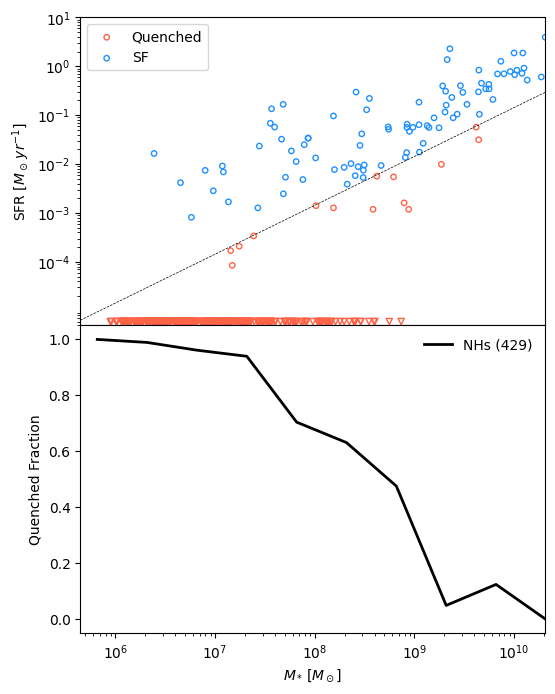

In [45]:
fig, axes = plt.subplots(2,1, figsize=(6,8), sharex=True)
plt.subplots_adjust(wspace=0, hspace=0)
x1 = np.min(allsats1['m']*0.5); x2 = np.max(allsats1['m'])

# using = [(allsats1, states1), (allsats2, states2)]
# for j in range(2):
# allsats = using[j][0]; states = using[j][1]
allsats = np.hstack((allsats1, allsats2))
states = np.hstack((states1, states2))
#----------------------------------------------------------------
ax = axes[0]
xs = allsats['m']; ys = allsats['SFR_mem']*1.
mask_zero = ys==0; ys[mask_zero] = 6e-6
mask_q = (ys/xs) < ssfrcut1
mask_udg = allsats['id']<0


ax.scatter(xs[~mask_zero & mask_q], ys[~mask_zero & mask_q], s=15, ec='tomato', fc='none', marker='o', label='Quenched')
ax.scatter(xs[~mask_zero & ~mask_q], ys[~mask_zero & ~mask_q], s=15, ec='dodgerblue', fc='none', marker='o', label='SF')
ax.scatter(xs[mask_zero], ys[mask_zero], s=20, ec='tomato', fc='none', marker='v')
ax.plot([x1,x2], [ssfrcut1*x1, ssfrcut1*x2], color='k', ls='--', lw=0.5)
ax.legend()

ax.set_yscale('log')
ax.set_ylim(5e-6, 10)
ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1])
ax.set_ylabel(r"SFR $[M_\odot\,yr^{-1}]$")
ax.set_xscale('log')
ax.set_xlim(x1,x2)
#----------------------------------------------------------------

mmin=5.5; mmax = 10.5; mdex = 0.5
mbins = 10**np.arange(mmin, mmax+mdex, mdex); mleng = len(mbins)-1
MX = 0.5*(mbins[1:] + mbins[:-1])

#----------------------------------------------------------------
ax = axes[1]
ls = '-'
mask = mask_zero | mask_q
QF = np.zeros(mleng)
for im in range(mleng):
    binmask = (xs > mbins[im]) & (xs < mbins[im+1])
    if(np.sum(binmask) == 0): QF[im] = np.nan
    QF[im] = np.sum(mask[binmask]) / np.sum(binmask)
ax.plot(MX, QF, color='k', lw=2, label=f'NHs ({len(xs)})', zorder=3, ls=ls)


ax.set_xscale('log')
ax.set_xlim(x1,x2)
ax.set_xlabel(r"$M_*\,[M_\odot]$")
ax.set_ylabel("Quenched Fraction")
ax.legend(frameon=False)
#----------------------------------------------------------------
plt.savefig("02_QF.png", dpi=400, transparent=False, bbox_inches='tight')
plt.show(); plt.close()

with error

In [58]:
np.mean([9.120663348185278,
9.121693121693124,
9.130511463844798,])

9.124289311241066

In [74]:
mao = np.genfromtxt("QF_SAGA.csv", comments='#', delimiter=',')
mao[0]

array([6.788     , 0.05621422, 0.        , 0.12211844, 0.65617433])

In [75]:
wetzel = np.genfromtxt("QF_LG.csv", comments='#', delimiter=',')
wetzel[0]

array([5.48853616, 0.94188862, 0.82808717, 0.95883777])

In [84]:
# # Cluver+17 line
# 6.487804878048781, -4.174825174825174
# 11.292682926829269, 1.2564102564102568
# # Davies+16 line
# 6.487804878048781, -3.4638694638694636
# 11.300813008130081, 0.5221445221445224
# # MW Bland-Hawthorn+16 point
# 10.699186991869919, 0.23076923076923106
# # M31 Yin+09, Ford+13
# 10.853658536585368, -0.6083916083916079
sfms = np.genfromtxt("SFMS.csv", comments='#', delimiter=',')
sfms

array([[ 6.48780488, -4.17482517],
       [11.29268293,  1.25641026],
       [ 6.48780488, -3.46386946],
       [11.30081301,  0.52214452],
       [10.69918699,  0.23076923],
       [10.85365854, -0.60839161]])

In [97]:
LG1[1]['BGG'].dtype

dtype([('nparts', '<i4'), ('id', '<i4'), ('timestep', '<i4'), ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4'), ('nbsub', '<i4'), ('nextsub', '<i4'), ('aexp', '<f8'), ('m', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('vx', '<f8'), ('vy', '<f8'), ('vz', '<f8'), ('Lx', '<f8'), ('Ly', '<f8'), ('Lz', '<f8'), ('r', '<f8'), ('a', '<f8'), ('b', '<f8'), ('c', '<f8'), ('ek', '<f8'), ('ep', '<f8'), ('et', '<f8'), ('spin', '<f8'), ('sigma', '<f8'), ('sigma_bulge', '<f8'), ('m_bulge', '<f8'), ('rvir', '<f8'), ('mvir', '<f8'), ('tvir', '<f8'), ('cvel', '<f8'), ('rho0', '<f8'), ('rc', '<f8'), ('halo_id', '<i4'), ('halo_nparts', '<i4'), ('halo_level', '<i4'), ('halo_host', '<i4'), ('halo_hostsub', '<i4'), ('halo_x', '<f8'), ('halo_y', '<f8'), ('halo_z', '<f8'), ('halo_vx', '<f8'), ('halo_vy', '<f8'), ('halo_vz', '<f8'), ('halo_mvir', '<f8'), ('halo_rvir', '<f8'), ('fcontam', '<f8'), ('dist', '<f8'), ('central', '?'), ('main', '?'), ('r200', '<f8'), ('m200', '<f8'), ('r200_code', '<f8'), (

  0%|          | 0/599 [00:00<?, ?it/s]

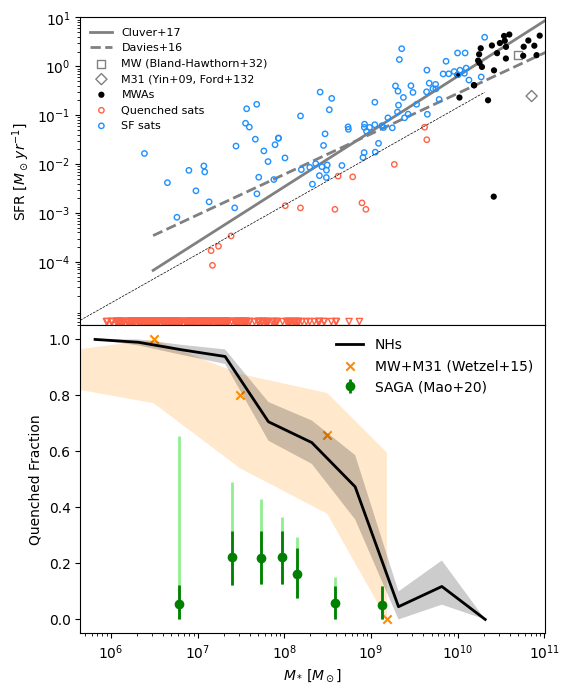

In [103]:
fig, axes = plt.subplots(2,1, figsize=(6,8), sharex=True)
plt.subplots_adjust(wspace=0, hspace=0)
x1 = np.min(allsats1['m']*0.5); x2 = np.max(allsats1['m'])


allsats = np.hstack((allsats1, allsats2))
states = np.hstack((states1, states2))
#----------------------------------------------------------------
ax = axes[0]
xs = allsats['m']; ys = allsats['SFR_mem']*1.
mask_zero = ys==0; ys[mask_zero] = 6e-6
mask_q = (ys/xs) < ssfrcut1
mask_udg = allsats['id']<0

ax.plot(10**sfms[:2,0], 10**sfms[:2,1], color='grey', lw=2, ls='-', label='Cluver+17', zorder=-1)
ax.plot(10**sfms[2:4,0], 10**sfms[2:4,1], color='grey', lw=2, ls='--', label='Davies+16', zorder=-1)
ax.scatter(10**sfms[4,0], 10**sfms[4,1], fc='none',ec='grey', s=32, marker='s', label='MW (Bland-Hawthorn+32)', zorder=-1)
ax.scatter(10**sfms[5,0], 10**sfms[5,1], fc='none',ec='grey', s=32, marker='D', label='M31 (Yin+09, Ford+132', zorder=-1)

iii=0
for key in keys1:
    BGG = LG1[key]['BGG']
    if(iii==0): ax.scatter(BGG['m'], BGG['sfr'], s=20, fc='k', ec='none', marker='o', lw=0.5, zorder=1, label='MWAs')
    else: ax.scatter(BGG['m'], BGG['sfr'], s=20, fc='k', ec='none', marker='o', lw=0.5, zorder=1)
    iii+=1
for key in keys2:
    BGG = LG2[key]['BGG']
    ax.scatter(BGG['m'], BGG['sfr'], s=20, fc='k', ec='none', marker='o', lw=0.5, zorder=1)

ax.scatter(xs[~mask_zero & mask_q], ys[~mask_zero & mask_q], s=15, ec='tomato', fc='none', marker='o', label='Quenched sats')
ax.scatter(xs[~mask_zero & ~mask_q], ys[~mask_zero & ~mask_q], s=15, ec='dodgerblue', fc='none', marker='o', label='SF sats')
ax.scatter(xs[mask_zero], ys[mask_zero], s=20, ec='tomato', fc='none', marker='v')
ax.plot([x1,x2], [ssfrcut1*x1, ssfrcut1*x2], color='k', ls='--', lw=0.5)
ax.legend(loc='upper left', frameon=False, fontsize=8)

ax.set_yscale('log')
ax.set_ylim(5e-6, 10)
ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1])
ax.set_ylabel(r"SFR $[M_\odot\,yr^{-1}]$")
ax.set_xscale('log')
ax.set_xlim(x1,x2)
#----------------------------------------------------------------

mmin=5.5; mmax = 10.5; mdex = 0.5
mbins = 10**np.arange(mmin, mmax+mdex, mdex); mleng = len(mbins)-1
MX = 0.5*(mbins[1:] + mbins[:-1])

#----------------------------------------------------------------
ax = axes[1]
ls = '-'
nboot = 599
QFs = np.zeros((nboot, mleng))
hist, _ = np.histogram(allsats['m'], bins = mbins)
for ib in tqdm(range(nboot)):
    sample = np.random.choice(allsats, len(allsats), replace=True)
    xs = sample['m']; ys = sample['SFR_mem']*1.
    mask_zero = ys==0; ys[mask_zero] = 6e-6; mask_q = (ys/xs) < ssfrcut1; mask = mask_zero | mask_q
    QF = np.zeros(mleng)
    for im in range(mleng):
        binmask = (xs > mbins[im]) & (xs < mbins[im+1])
        if(np.sum(binmask) == 0): QF[im] = np.nan
        else: QF[im] = np.sum(mask[binmask]) / np.sum(binmask)
    QFs[ib] = QF
q16, q50, q84 = np.nanpercentile(QFs, [16,50,84], axis=0)

ax.fill_between(10**wetzel[:,0], wetzel[:,2], wetzel[:,3], alpha=0.2, ec='none', fc='darkorange')
ax.scatter(10**wetzel[:,0], wetzel[:,1], color='darkorange', marker='x', label=f'MW+M31 (Wetzel+15)')

ax.errorbar(10**mao[:,0], mao[:,1], yerr=[mao[:,1]-mao[:,2], mao[:,4]-mao[:,1]], 
            ms=6, mec='none',mfc='lightgreen', linewidth=0, ecolor='lightgreen', mew=2, elinewidth=2, marker='o', 
            color='lightgreen', ls='-')
ax.errorbar(10**mao[:,0], mao[:,1], yerr=[mao[:,1]-mao[:,2], mao[:,3]-mao[:,1]], 
            ms=7, mec='none',mfc='g', linewidth=0, ecolor='g', mew=2, elinewidth=2, marker='o', 
            color='g', ls='-', label='SAGA (Mao+20)')



ax.fill_between(MX, q16, q84, alpha=0.2, ec='none', fc='k')
ax.plot(MX, q50, color='k', lw=2, label=f'NHs', ls=ls)

# mask = mask_zero | mask_q
# QF = np.zeros(mleng)
# for im in range(mleng):
#     binmask = (xs > mbins[im]) & (xs < mbins[im+1])
#     if(np.sum(binmask) == 0): QF[im] = np.nan
#     QF[im] = np.sum(mask[binmask]) / np.sum(binmask)
# ax.plot(MX, QF, color='k', lw=2, label=f'NHs ({len(xs)})', zorder=3, ls=ls)


ax.set_xscale('log')
ax.set_xlim(x1,x2*5)
ax.set_xlabel(r"$M_*\,[M_\odot]$")
ax.set_ylabel("Quenched Fraction")
leg = ax.legend(frameon=False)
handles, labels = ax.get_legend_handles_labels()
order = [1,0,2]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
#----------------------------------------------------------------
plt.savefig("02_QFe.png", dpi=400, transparent=False, bbox_inches='tight')
plt.show(); plt.close()

  0%|          | 0/599 [00:00<?, ?it/s]

  0%|          | 0/599 [00:00<?, ?it/s]

  0%|          | 0/599 [00:00<?, ?it/s]

/home/jeon/.conda/envs/jeonpy/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


  0%|          | 0/599 [00:00<?, ?it/s]

  0%|          | 0/599 [00:00<?, ?it/s]

  0%|          | 0/599 [00:00<?, ?it/s]

  0%|          | 0/599 [00:00<?, ?it/s]

  0%|          | 0/599 [00:00<?, ?it/s]

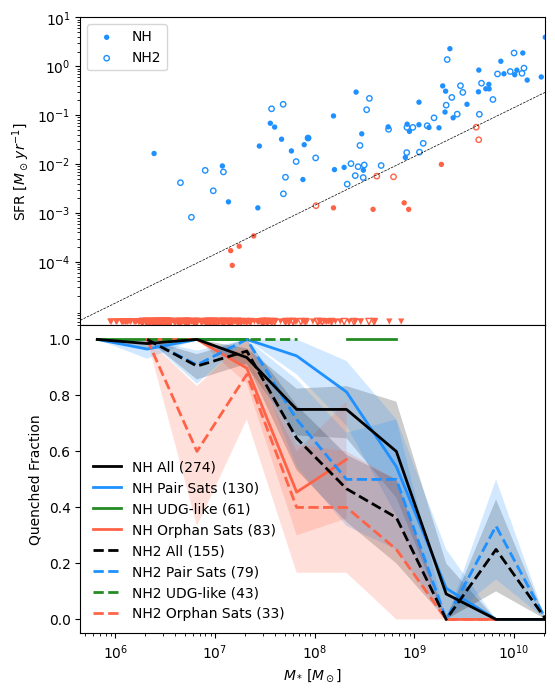

In [39]:
fig, axes = plt.subplots(2,1, figsize=(6,8), sharex=True)
plt.subplots_adjust(wspace=0, hspace=0)
x1 = np.min(allsats1['m']*0.5); x2 = np.max(allsats1['m'])

using = [(allsats1, states1), (allsats2, states2)]
for j in range(2):
    prefix = "NH" if(j==0) else "NH2"
    ls = '-' if(j==0) else '--'
    allsats = using[j][0]; states = using[j][1]
    #----------------------------------------------------------------
    ax = axes[0]
    xs = allsats['m']; ys = allsats['SFR_mem']*1.
    mask_zero = ys==0; ys[mask_zero] = 6e-6
    mask_q = (ys/xs) < ssfrcut1
    mask_udg = allsats['id']<0

    if(j==0):
        ax.scatter(xs[~mask_zero & mask_q], ys[~mask_zero & mask_q], s=15, fc='tomato', ec='none', marker='o')
        ax.scatter(xs[~mask_zero & ~mask_q], ys[~mask_zero & ~mask_q], s=15, fc='dodgerblue', ec='none', marker='o', label=prefix)
        ax.scatter(xs[mask_zero], ys[mask_zero], s=20, fc='tomato', ec='none', marker='v')
    else:
        ax.scatter(xs[~mask_zero & mask_q], ys[~mask_zero & mask_q], s=15, ec='tomato', fc='none', marker='o')
        ax.scatter(xs[~mask_zero & ~mask_q], ys[~mask_zero & ~mask_q], s=15, ec='dodgerblue', fc='none', marker='o', label=prefix)
        ax.scatter(xs[mask_zero], ys[mask_zero], s=20, ec='tomato', fc='none', marker='v')
        ax.plot([x1,x2], [ssfrcut1*x1, ssfrcut1*x2], color='k', ls='--', lw=0.5)

        ax.set_yscale('log')
        ax.set_ylim(5e-6, 10)
        ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1])
        ax.set_ylabel(r"SFR $[M_\odot\,yr^{-1}]$")
        ax.set_xscale('log')
        ax.set_xlim(x1,x2)
        ax.legend()
    #----------------------------------------------------------------

    mmin=5.5; mmax = 10.5; mdex = 0.5
    mbins = 10**np.arange(mmin, mmax+mdex, mdex); mleng = len(mbins)-1
    MX = 0.5*(mbins[1:] + mbins[:-1])

    #----------------------------------------------------------------
    ax = axes[1]
    nboot = 599
    QFs = np.zeros((nboot, mleng))
    hist, _ = np.histogram(allsats['m'], bins = mbins)
    for ib in tqdm(range(nboot)):
        sample = np.random.choice(allsats, len(allsats), replace=True)
        xs = sample['m']; ys = sample['SFR_mem']*1.
        mask_zero = ys==0; ys[mask_zero] = 6e-6; mask_q = (ys/xs) < ssfrcut1; mask = mask_zero | mask_q
        QF = np.zeros(mleng)
        for im in range(mleng):
            binmask = (xs > mbins[im]) & (xs < mbins[im+1])
            if(np.sum(binmask) == 0): QF[im] = np.nan
            else: QF[im] = np.sum(mask[binmask]) / np.sum(binmask)
        QFs[ib] = QF
    q16, q50, q84 = np.nanpercentile(QFs, [16,50,84], axis=0)
    ax.fill_between(MX, q16, q84, alpha=0.2, ec='none', fc='k')
    ax.plot(MX, q50, color='k', lw=2, zorder=3, label=f'{prefix} All ({len(sample)})', ls=ls)

    iters = ['pair', 'upair', 'orphan']
    colors = ['dodgerblue', 'forestgreen', 'tomato']
    names = ["Pair Sats", "UDG-like", "Orphan Sats"]
    for iiter, icolor, iname in zip(iters, colors, names):
        samples = allsats[states == iiter]
        hist, _ = np.histogram(samples['m'], bins = mbins)
        QFs = np.zeros((nboot, mleng))
        for ib in tqdm(range(nboot)):
            sample = np.random.choice(samples, len(samples), replace=True)
            xs = sample['m']; ys = sample['SFR_mem']*1.
            mask_zero = ys==0; ys[mask_zero] = 6e-6; mask_q = (ys/xs) < ssfrcut1; mask = mask_zero | mask_q
            QF = np.zeros(mleng)
            for im in range(mleng):
                binmask = (xs > mbins[im]) & (xs < mbins[im+1])
                if(np.sum(binmask) == 0): QF[im] = np.nan
                else:
                    QF[im] = np.sum(mask[binmask]) / np.sum(binmask)
            QFs[ib] = QF
        q16, q50, q84 = np.nanpercentile(QFs, [16,50,84], axis=0)
        ax.fill_between(MX, q16, q84, alpha=0.2, ec='none', fc=icolor)
        ax.plot(MX, q50, color=icolor, lw=2, label=f"{prefix} {iname} ({len(sample)})", ls=ls)

    ax.set_xscale('log')
    ax.set_xlim(x1,x2)
    ax.set_xlabel(r"$M_*\,[M_\odot]$")
    ax.set_ylabel("Quenched Fraction")
    ax.legend(frameon=False)
    #----------------------------------------------------------------
plt.savefig("02_QFe.png", dpi=400, transparent=False, bbox_inches='tight')
plt.show(); plt.close()

  0%|          | 0/599 [00:00<?, ?it/s]

  0%|          | 0/599 [00:00<?, ?it/s]

/home/jeon/.conda/envs/jeonpy/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


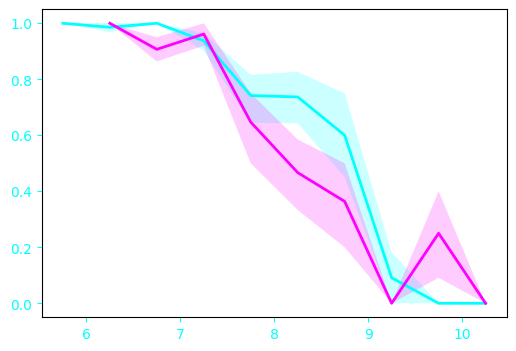

In [40]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
x1 = np.min(allsats1['m']*0.5); x2 = np.max(allsats1['m'])


# xs = allsats['m']; ys = allsats['SFR_mem']*1.
# mask_zero = ys==0; ys[mask_zero] = 6e-6
# mask_q = (ys/xs) < ssfrcut
# mask_udg = allsats['id']<0
mmin=5.5; mmax = 10.5; mdex = 0.5
mbins = np.arange(mmin, mmax+mdex, mdex); mleng = len(mbins)-1
MX = 0.5*(mbins[1:] + mbins[:-1])

#----------------------------------------------------------------
nboot = 599
QFs = np.zeros((nboot, mleng))
hist, _ = np.histogram(allsats1['m'], bins = mbins)
for ib in tqdm(range(nboot)):
    sample = np.random.choice(allsats1, len(allsats1), replace=True)
    xs = sample['m']; ys = sample['SFR_mem']*1.
    mask_zero = ys==0; ys[mask_zero] = 6e-6; mask_q = (ys/xs) < ssfrcut1; mask = mask_zero | mask_q
    QF = np.zeros(mleng)
    for im in range(mleng):
        binmask = (np.log10(xs) > mbins[im]) & (np.log10(xs) < mbins[im+1])
        if(np.sum(binmask) == 0): QF[im] = np.nan
        else: QF[im] = np.sum(mask[binmask]) / np.sum(binmask)
    QFs[ib] = QF
q16, q50, q84 = np.nanpercentile(QFs, [16,50,84], axis=0)

ax.fill_between(MX, q16, q84, alpha=0.2, ec='none', fc='cyan')
ax.plot(MX, q50, color='cyan', lw=2, zorder=3)#, label=f'All Sats {len(sample)}')
#----------------------------------------------------------------
QFs = np.zeros((nboot, mleng))
hist, _ = np.histogram(allsats2['m'], bins = mbins)
for ib in tqdm(range(nboot)):
    sample = np.random.choice(allsats2, len(allsats2), replace=True)
    xs = sample['m']; ys = sample['SFR_mem']*1.
    mask_zero = ys==0; ys[mask_zero] = 6e-6; mask_q = (ys/xs) < ssfrcut1; mask = mask_zero | mask_q
    QF = np.zeros(mleng)
    for im in range(mleng):
        binmask = (np.log10(xs) > mbins[im]) & (np.log10(xs) < mbins[im+1])
        if(np.sum(binmask) == 0): QF[im] = np.nan
        else: QF[im] = np.sum(mask[binmask]) / np.sum(binmask)
    QFs[ib] = QF
q16, q50, q84 = np.nanpercentile(QFs, [16,50,84], axis=0)

ax.fill_between(MX, q16, q84, alpha=0.2, ec='none', fc='magenta')
ax.plot(MX, q50, color='magenta', lw=2, zorder=3)#, label=f'All Sats {len(sample)}')
#----------------------------------------------------------------




ax.tick_params(axis='both', colors='cyan')
ax.xaxis.label.set_color('cyan')
ax.yaxis.label.set_color('cyan')
ax.set_facecolor('none')
fig.set_facecolor('none')
#----------------------------------------------------------------
plt.savefig("02_QF_transparent.png", dpi=400, transparent=True, bbox_inches='tight')
plt.show(); plt.close()

In [16]:
BGG.dtype

NameError: name 'BGG' is not defined

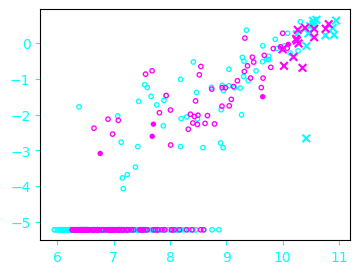

In [42]:
fig, ax = plt.subplots(1,1, figsize=(4,3))
x1 = np.min(allsats1['m']*0.5); x2 = np.max(allsats1['m'])

color = 'cyan'
for key in keys1:    
    BGG = LG1[key]['BGG']
    ax.scatter(np.log10(BGG['m']), np.log10(BGG['sfr']), s=30, ec=color, fc='none', marker='x', label=key)
    sats = LG1[key]['sats']
    xs = np.log10(sats['m']); ys = sats['SFR_mem']*1.
    mask_zero = ys==0; ys[mask_zero] = 6e-6
    ys = np.log10(ys)
    pairind = isin(sats['id'], real['gid'][real['state']!='upair'])
    ax.scatter(xs[pairind], ys[pairind], s=15, fc=color, ec='none', marker='o')
    ax.scatter(xs[~pairind], ys[~pairind], s=10, ec=color, fc='none', marker='o', lw=0.95)

color = 'magenta'
for key in keys2:    
    BGG = LG2[key]['BGG']
    ax.scatter(np.log10(BGG['m']), np.log10(BGG['sfr']), s=30, ec=color, fc='none', marker='x', label=key)
    sats = LG2[key]['sats']
    xs = np.log10(sats['m']); ys = sats['SFR_mem']*1.
    mask_zero = ys==0; ys[mask_zero] = 6e-6
    ys = np.log10(ys)
    pairind = isin(sats['id'], real['gid'][real['state']!='upair'])
    ax.scatter(xs[pairind], ys[pairind], s=15, fc=color, ec='none', marker='o')
    ax.scatter(xs[~pairind], ys[~pairind], s=10, ec=color, fc='none', marker='o', lw=0.95)


ax.tick_params(axis='both', colors='cyan')
ax.xaxis.label.set_color('cyan')
ax.yaxis.label.set_color('cyan')
ax.set_facecolor('none')
fig.set_facecolor('none')
#----------------------------------------------------------------
plt.savefig("02_SFMS_transparent.png", dpi=400, transparent=True, bbox_inches='tight')
plt.show(); plt.close()